In [22]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

DATASET_PARENT_DIRECTORY = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/data"
METADATA_LOCATION = "/kaggle/input/nasa-battery-dataset/cleaned_dataset/metadata.csv"
metadata_df = pd.read_csv(METADATA_LOCATION)
metadata_df.head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN


In [5]:
metadata_df[metadata_df["type"] == "discharge"].head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
0,discharge,[2010. 7. 21. 15. 0. ...,4,B0047,0,1,00001.csv,1.6743047446975208,NaN,NaN
4,discharge,[2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...,4,B0047,4,5,00005.csv,1.5243662105099023,NaN,NaN
6,discharge,[2.010e+03 7.000e+00 2.200e+01 1.000e+00 4.000...,4,B0047,6,7,00007.csv,1.5080762969973425,NaN,NaN
8,discharge,[2010. 7. 22. 6. 16. ...,4,B0047,8,9,00009.csv,1.4835577960067696,NaN,NaN
10,discharge,[2010. 7. 22. 10. 51. ...,4,B0047,10,11,00011.csv,1.4671391666146525,NaN,NaN


In [6]:
subdata_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, "00001.csv"))
subdata_df

,Voltage_measured,Current_measured,Temperature_measured,Current_load,Voltage_load,Time
0,4.246711,0.000252,6.212696,0.0002,0.000,0.000
1,4.246764,-0.001411,6.234019,0.0002,4.262,9.360
2,4.039277,-0.995093,6.250255,1.0000,3.465,23.281
3,4.019506,-0.996731,6.302176,1.0000,3.451,36.406
4,4.004763,-0.992845,6.361645,1.0000,3.438,49.625
...,...,...,...,...,...,...
485,3.303251,-0.001760,9.662331,0.0004,0.000,6382.063
486,3.310303,-0.000756,9.390489,0.0002,0.000,6395.547
487,3.317351,-0.003318,9.137008,0.0002,0.000,6409.063
488,3.323387,-0.002291,8.972806,0.0002,0.000,6422.625


In [7]:
metadata_df[metadata_df["type"] == "charge"].head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
2,charge,[2010. 7. 21. 17. 25. ...,4,B0047,2,3,00003.csv,NaN,NaN,NaN
5,charge,[2010. 7. 21. 22. 38. ...,4,B0047,5,6,00006.csv,NaN,NaN,NaN
7,charge,[2010. 7. 22. 3. 14. ...,4,B0047,7,8,00008.csv,NaN,NaN,NaN
9,charge,[2010. 7. 22. 7. 50. ...,4,B0047,9,10,00010.csv,NaN,NaN,NaN
11,charge,[2010. 7. 22. 12. 25. ...,4,B0047,11,12,00012.csv,NaN,NaN,NaN


In [8]:
subdata_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, "00003.csv"))
subdata_df

,Voltage_measured,Current_measured,Temperature_measured,Current_charge,Voltage_charge,Time
0,3.486189,0.001417,5.990142,-0.0006,0.002,0.000
1,3.746592,1.489057,5.992528,1.4995,4.618,2.594
2,3.775438,1.490426,5.991340,1.4995,4.669,8.922
3,3.794844,1.491527,6.003554,1.4995,4.694,15.234
4,3.811691,1.491425,6.026729,1.4995,4.707,21.516
...,...,...,...,...,...,...
1616,4.213930,0.053584,5.650154,0.0534,4.263,10776.438
1617,4.214202,0.053244,5.669955,0.0534,4.263,10783.156
1618,4.213894,0.054503,5.687639,0.0534,4.263,10789.875
1619,4.214060,0.051309,5.708888,0.0534,4.263,10796.578


In [9]:
metadata_df[metadata_df["type"] == "impedance"].head()

,type,start_time,ambient_temperature,battery_id,test_id,uid,filename,Capacity,Re,Rct
1,impedance,[2010. 7. 21. 16. 53. ...,24,B0047,1,2,00002.csv,NaN,0.05605783343888099,0.20097016584458333
3,impedance,[2010 7 21 20 31 5],24,B0047,3,4,00004.csv,NaN,0.05319185850921101,0.16473399914864734
13,impedance,[2010. 7. 22. 17. 3. ...,24,B0047,13,14,00014.csv,NaN,0.05963791501051059,0.21039872263834902
15,impedance,[2010. 7. 22. 20. 40. 25.5],24,B0047,15,16,00016.csv,NaN,0.05512505361624278,0.1754882075917004
17,impedance,[2010. 7. 23. 11. 35. ...,24,B0047,17,18,00018.csv,NaN,0.058878485312444453,0.19095687096090014


In [10]:
subdata_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, "00002.csv"))
subdata_df

,Sense_current,Battery_current,Current_ratio,Battery_impedance,Rectified_Impedance
0,(928.3472290039062-48.499576568603516j),(228.7861328125-70.94481658935547j),(3.76172584438583+0.9544956717274271j),(0.19021741554080737+0.07913959666077047j),(0.17493022756754967-0.02331644173631698j)
1,(922.0059814453125-52.15481185913086j),(233.29783630371094-67.84492492675781j),(3.70383574337748+0.8535511912426126j),(0.012482111540534805+0.03664975726191017j),(0.16866854345060991-0.024717137242854174j)
2,(920.0405883789062-52.19926452636719j),(236.62075805664062-67.22105407714844j),(3.6558702379340415+0.8179848126025503j),(0.030461237041852884-0.08529386061204824j),(0.16107808875912483-0.024114907529065532j)
3,(914.2005615234375-52.371726989746094j),(242.2973175048828-66.45936584472656j),(3.564190338159781+0.7614698525522733j),(0.14229365598447172-0.12192216177062407j),(0.14924381603096853-0.02372905366581296j)
4,(911.2781372070312-45.477928161621094j),(246.62347412109375-65.4150161743164j),(3.4978434135716947+0.7433743116536402j),(0.24388219819020493-0.08033187245076714j),(0.14049811021506395-0.022851601640846698j)
5,(907.116943359375-46.32453536987305j),(251.11593627929688-65.69110107421875j),(3.426140647581949+0.7117924049476518j),(0.303109266599245-0.01100015291136107j),(0.1311573351226623-0.02242361032794129j)
6,(899.554443359375-43.06085968017578j),(259.12646484375-67.00004577636719j),(3.2942234027295925+0.6855813018072434j),(0.32709058487432013+0.05145705088260462j),(0.12304603255413803-0.0195099331278606j)
7,(891.207275390625-43.172672271728516j),(266.564697265625-68.21566772460938j),(3.176714891409828+0.6509828833170116j),(0.33089967640944123+0.09355670635190765j),(0.11344810854459421-0.017644032709853628j)
8,(885.2266845703125-43.83500289916992j),(273.4709777832031-69.10552978515625j),(3.080782312186481+0.6182158425280606j),(0.3254359075820158+0.11409318785479901j),(0.10803339194768323-0.01638562897701378j)
9,(877.4107666015625-43.043678283691406j),(281.1755065917969-67.8630599975586j),(2.9836528086978147+0.5670342101181585j),(0.31603270085729296+0.1168731107735024j),(0.10034982474252357-0.013454518333835989j)


In [12]:
sample_charge_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, "00003.csv"))
sample_discharge_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, "00001.csv"))

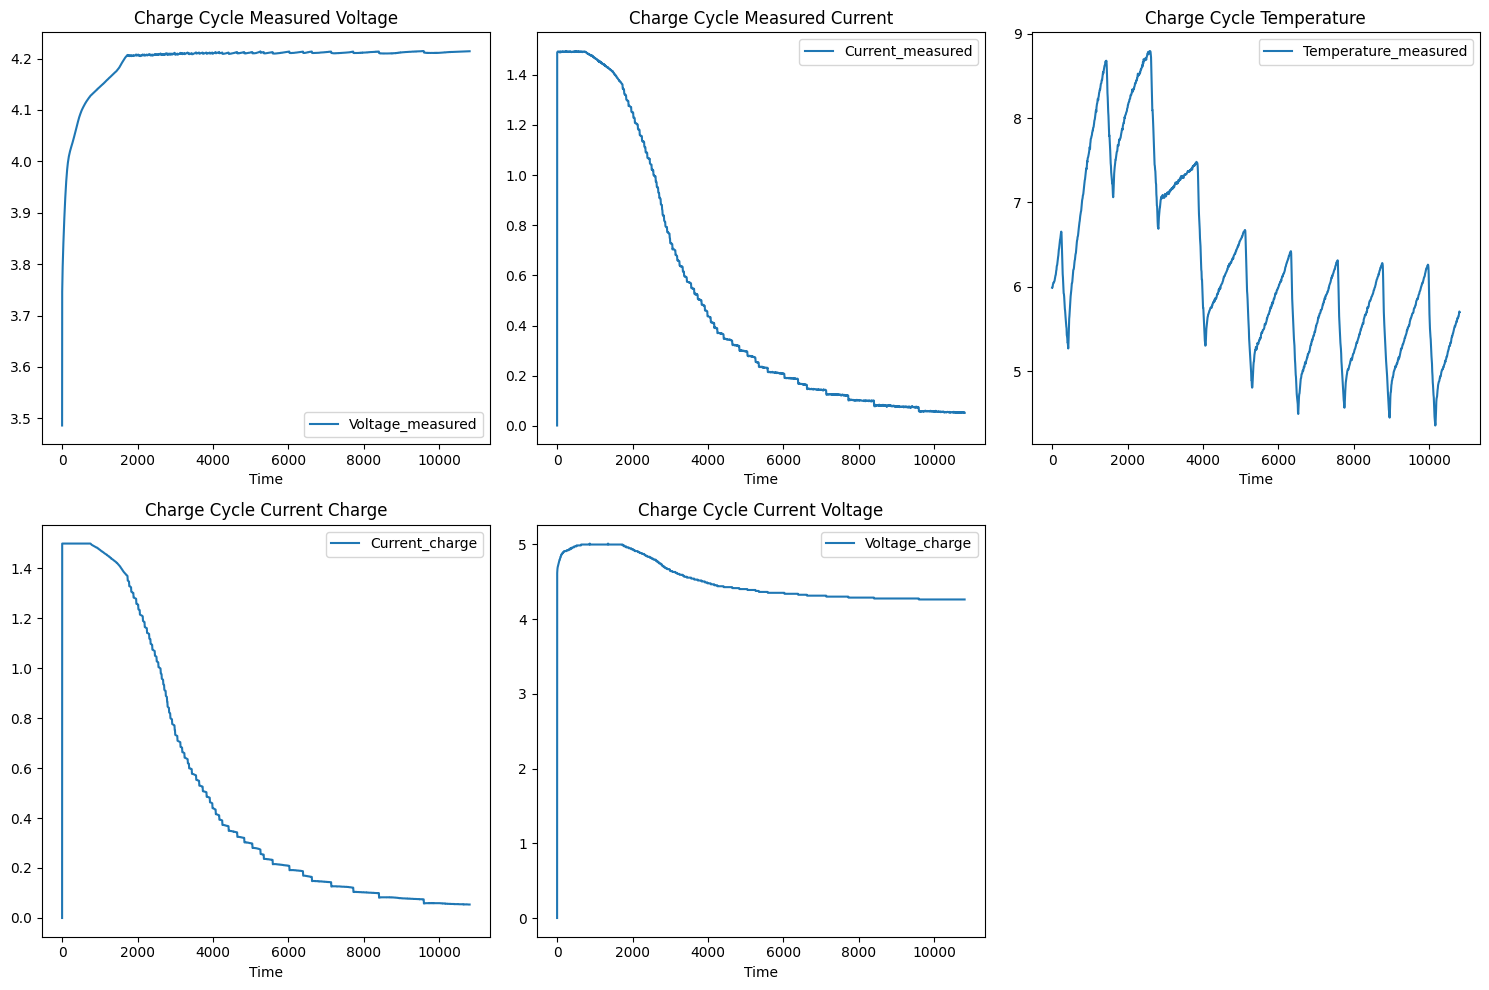

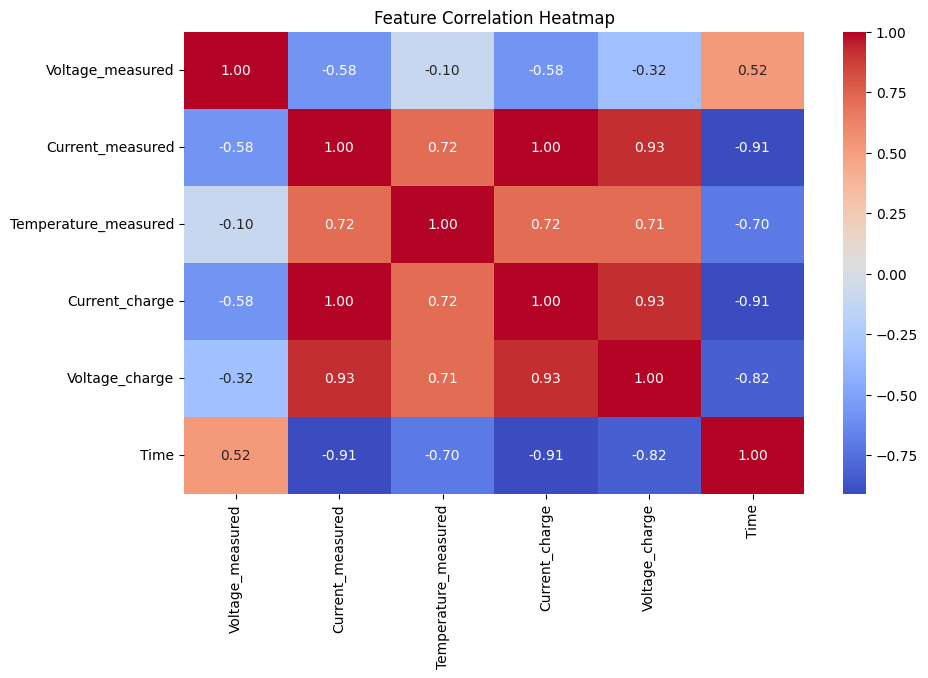

In [17]:
fig, ax = plt.subplots(2, 3, figsize=(15, 10))
sample_charge_df.plot(x="Time", y="Voltage_measured", ax=ax[0, 0], title="Charge Cycle Measured Voltage")
sample_charge_df.plot(x="Time", y="Current_measured", ax=ax[0, 1], title="Charge Cycle Measured Current")
sample_charge_df.plot(x="Time", y="Temperature_measured", ax=ax[0, 2], title="Charge Cycle Temperature")
sample_charge_df.plot(x="Time", y="Current_charge", ax=ax[1, 0], title="Charge Cycle Current Charge")
sample_charge_df.plot(x="Time", y="Voltage_charge", ax=ax[1, 1], title="Charge Cycle Current Voltage")
fig.delaxes(ax[1, 2])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(sample_charge_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
processed_data = []
cycle_id = 0

for idx, row in metadata_df.iterrows():
    cycle_df = pd.read_csv(os.path.join(DATASET_PARENT_DIRECTORY, row["filename"]))
    battery_id = row["battery_id"]
    if row["type"] == "discharge":
        cycle_id += 1
        aggregated_features = {
            "battery_id": battery_id,
            "cycle_id": cycle_id,
            "capacity": float(row["Capacity"]) if row["Capacity"].replace('.', '', 1).isdigit() and float(row["Capacity"]) > 0 else None,
            "discharge_time": cycle_df["Time"].iloc[-1] - cycle_df["Time"].iloc[0],
            "mean_discharge_voltage": float(cycle_df["Voltage_measured"].mean()),
            "std_discharge_voltage": float(cycle_df["Voltage_measured"].std()),
            "mean_discharge_temperature": float(cycle_df["Temperature_measured"].mean()),
            "std_discharge_temperature": float(cycle_df["Temperature_measured"].std())
        }
        aggregated_features["mean_voltage_discharge_rate"] = aggregated_features["mean_discharge_voltage"] / aggregated_features["discharge_time"]

        # Constant current duration
        max_current = cycle_df["Current_measured"].max()
        cc_duration_df = cycle_df[cycle_df["Current_measured"] < 0.95 * max_current]
        if not cc_duration_df.empty:
            aggregated_features["constant_current_duration"] = cc_duration_df["Time"].iloc[-1] - cc_duration_df["Time"].iloc[0]
        else:
            aggregated_features["constant_current_duration"] = 0

        aggregated_features["re"] = None
        aggregated_features["rct"] = None
    elif row["type"] == "charge":
        aggregated_features.update({
            "charge_time": cycle_df["Time"].iloc[-1] - cycle_df["Time"].iloc[0],
            "mean_charge_voltage": float(cycle_df["Voltage_measured"].mean()),
            "std_charge_voltage": float(cycle_df["Voltage_measured"].std()),
            "mean_charge_current": float(cycle_df["Current_measured"].mean()),
            "std_charge_current": float(cycle_df["Current_measured"].std()),
            "mean_charge_temperature": float(cycle_df["Temperature_measured"].mean()),
            "std_charge_temperature": float(cycle_df["Temperature_measured"].std())
        })
        processed_data.append(aggregated_features)
    elif row["type"] == "impedance":
        try:
            re_value = float(row["Re"])
            rct_value = float(row["Rct"])
            if aggregated_features.get("re") is not None and aggregated_features.get("rct") is not None:
                aggregated_features["re"] = (aggregated_features["re"] + re_value) / 2
                aggregated_features["rct"] = (aggregated_features["rct"] + rct_value) / 2
            else:
                aggregated_features["re"] = re_value
                aggregated_features["rct"] = rct_value
        except ValueError:
            continue
processed_df = pd.DataFrame(processed_data)
processed_df[["capacity", "re", "rct"]] = processed_df[["capacity", "re", "rct"]].ffill()
processed_df['rul'] = processed_df.groupby('battery_id')['cycle_id'].transform('max') - processed_df['cycle_id']
processed_df.drop(columns=['battery_id', 'cycle_id'], inplace=True)

In [19]:
processed_df

,capacity,discharge_time,mean_discharge_voltage,std_discharge_voltage,mean_discharge_temperature,std_discharge_temperature,mean_voltage_discharge_rate,constant_current_duration,re,rct,charge_time,mean_charge_voltage,std_charge_voltage,mean_charge_current,std_charge_current,mean_charge_temperature,std_charge_temperature,rul
0,1.674305,6436.141,3.475266,0.284626,8.272423,1.455269,0.000540,6426.781,0.054625,0.182852,10803.313,4.193521,0.054022,0.520792,0.525708,6.279191,1.080534,71
1,1.524366,5650.265,3.476559,0.272495,8.210715,1.240161,0.000615,5650.265,0.054625,0.182852,10802.078,4.187504,0.074522,0.518686,0.517950,6.414351,1.270148,70
2,1.508076,5590.907,3.470767,0.278535,7.954455,1.416882,0.000621,5590.907,0.054625,0.182852,10807.688,4.189655,0.071733,0.513528,0.513308,6.263927,1.227796,69
3,1.483558,5543.610,3.467551,0.278416,7.985865,1.378159,0.000626,5543.610,0.054625,0.182852,10805.687,4.191918,0.067646,0.507374,0.510303,6.251470,1.224826,68
4,1.467139,5499.046,3.462839,0.282585,8.009427,1.323355,0.000630,5489.671,0.054625,0.182852,10804.078,4.193113,0.065585,0.501276,0.506706,6.214979,1.348284,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2810,1.028527,2345.000,3.370549,0.330330,10.889278,2.661229,0.001437,2345.000,0.098021,0.149828,10803.219,4.201560,0.036670,0.372899,0.461919,6.126430,1.248580,4
2811,0.981684,2363.047,3.358032,0.355463,11.125862,3.018736,0.001421,2363.047,0.098021,0.149828,10803.406,4.201952,0.036339,0.370873,0.458506,6.082476,1.265160,3
2812,1.012712,2316.687,3.330593,0.355444,11.180258,3.021877,0.001438,2316.687,0.097744,0.153822,10802.032,4.204044,0.027451,0.377963,0.449038,5.921926,1.009685,2
2813,1.020138,2322.000,3.345081,0.344262,11.102810,2.860820,0.001441,2322.000,0.097744,0.153822,10804.016,4.200754,0.038302,0.377056,0.461628,6.168347,1.273061,1


In [20]:
x = processed_df.drop(columns=['rul'])
y = processed_df['rul']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [26]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error


xgb_model = xgb.XGBRegressor(
    n_estimators=500,       # number of boosting rounds (trees)
    learning_rate=0.05,     # step size shrinkage
    max_depth=5,            # maximum tree depth
    subsample=0.8,          # fraction of samples per tree
    colsample_bytree=0.8,   # fraction of features per tree
    random_state=42
)
xgb_model.fit(x_train, y_train)
y_pred = xgb_model.predict(x_test)
print(y_pred[:10])

[ 37.27573   23.306412   6.034438  24.118465  59.444942 102.26166
  70.61429   22.154634  71.07366   44.213547]


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {rmse:.2f}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Test MAE: {mae:.2f}")

r2 = r2_score(y_test, y_pred)
print(f"Test R^2 Score: {r2:.2f}")

Test MSE: 151.28
Test RMSE: 12.30
Test MAE: 5.54
Test R^2 Score: 0.94


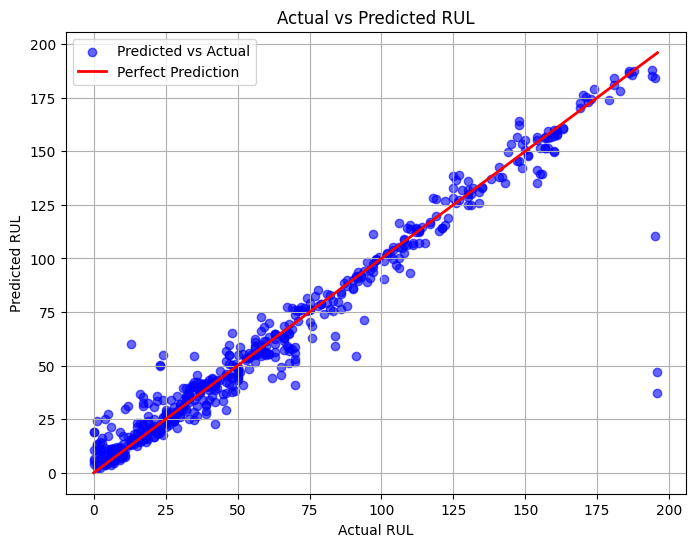

In [28]:

plt.figure(figsize=(8, 6))

# Scatter plot: predicted vs actual
plt.scatter(y_test, y_pred, color='blue', alpha=0.6, label='Predicted vs Actual')

# Perfect prediction line
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()


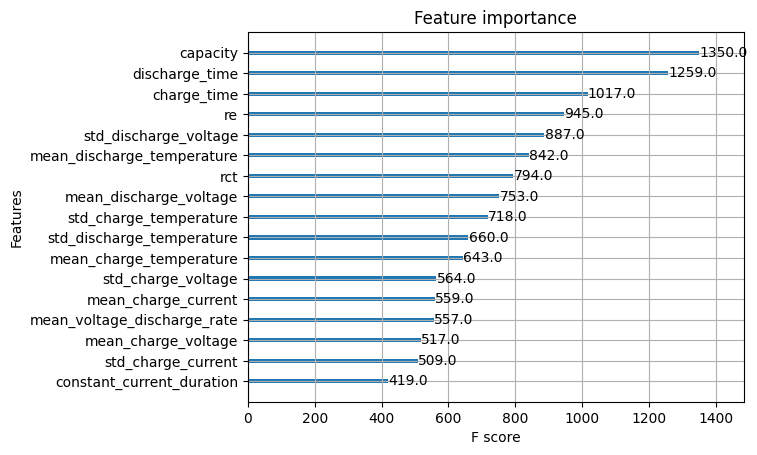

In [48]:
xgb.plot_importance(xgb_model)
plt.show()

In [29]:

baseline_model = LinearRegression()


baseline_model.fit(x_train, y_train)

y_pred_baseline = baseline_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred_baseline)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_baseline)

print(f"Baseline Model RMSE: {rmse:.2f}")
print(f"Baseline Model R^2 Score: {r2:.2f}")


Baseline Model RMSE: 38.79
Baseline Model R^2 Score: 0.40


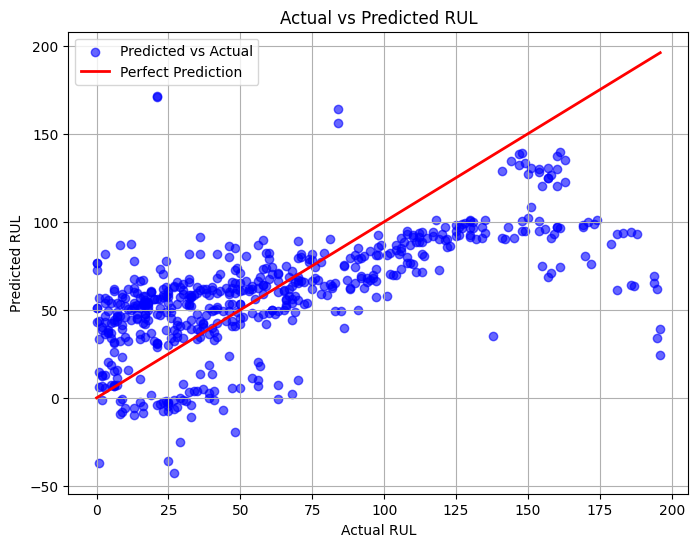

In [30]:
plt.figure(figsize=(8, 6))


plt.scatter(y_test, y_pred_baseline, color='blue', alpha=0.6, label='Predicted vs Actual')


plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()


In [32]:
ridge_model = Ridge(alpha=1.0, random_state=42)  # alpha controls regularization strength


ridge_model.fit(x_train, y_train)

y_pred_ridge = ridge_model.predict(x_test)

mse = mean_squared_error(y_test, y_pred_ridge)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred_ridge)

print(f"Ridge Regression RMSE: {rmse:.2f}")
print(f"Ridge Regression R^2 Score: {r2:.2f}")

Ridge Regression RMSE: 38.74
Ridge Regression R^2 Score: 0.40


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.24663e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


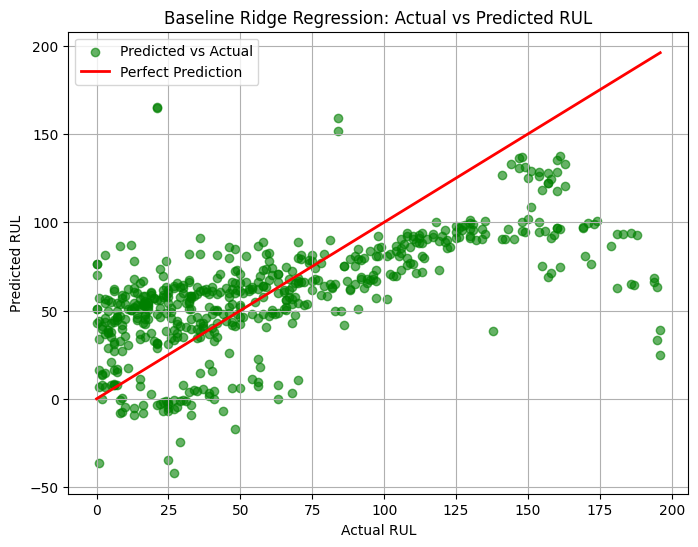

In [35]:
y_pred_ridge = ridge_model.predict(x_test)

plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_ridge, color='green', alpha=0.6, label='Predicted vs Actual')

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, label='Perfect Prediction')

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Baseline Ridge Regression: Actual vs Predicted RUL")
plt.legend()
plt.grid(True)
plt.show()


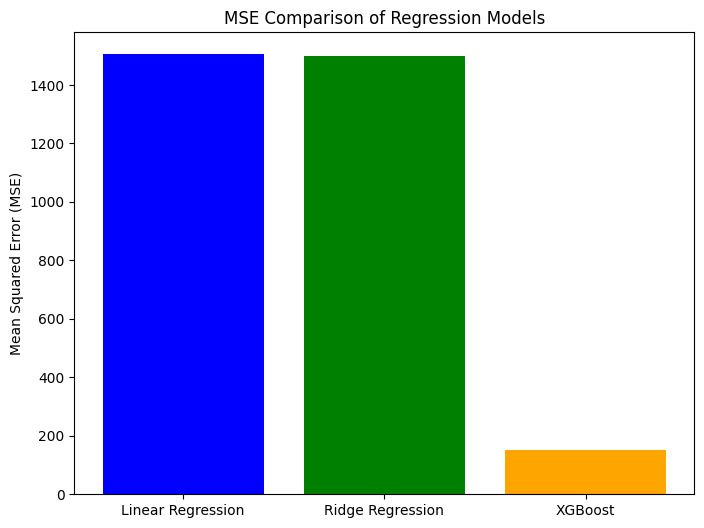

In [40]:
mse_values = {
    "Linear Regression": mean_squared_error(y_test, y_pred_baseline),
    "Ridge Regression": mean_squared_error(y_test, y_pred_ridge),
    "XGBoost": mean_squared_error(y_test, y_pred)
}

# Plot MSE comparison
plt.figure(figsize=(8, 6))
plt.bar(mse_values.keys(), mse_values.values(), color=['blue', 'green', 'orange'])
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE Comparison of Regression Models")
plt.show()

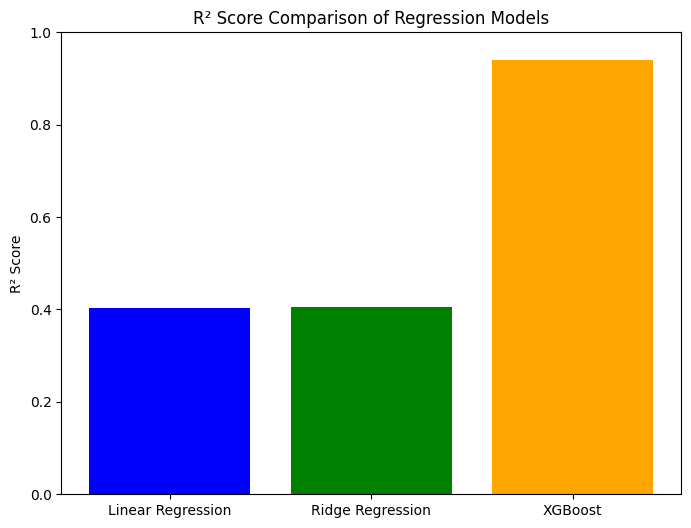

In [41]:
r2_values = {
    "Linear Regression": r2_score(y_test, y_pred_baseline),
    "Ridge Regression": r2_score(y_test, y_pred_ridge),
    "XGBoost": r2_score(y_test, y_pred)
}

plt.figure(figsize=(8, 6))
plt.bar(r2_values.keys(), r2_values.values(), color=['blue', 'green', 'orange'])
plt.ylabel("R² Score")
plt.title("R² Score Comparison of Regression Models")
plt.ylim(0, 1)
plt.show()

In [42]:

# Combine actual and predicted values in one DataFrame
predictions_df = x_test.copy()
predictions_df['Actual_RUL'] = y_test
predictions_df['Linear_Prediction'] = y_pred_baseline
predictions_df['Ridge_Prediction'] = y_pred_ridge
predictions_df['XGBoost_Prediction'] = y_pred


print(predictions_df.head())


      capacity  discharge_time  mean_discharge_voltage  std_discharge_voltage  \
450   0.441223        1397.000                3.515665               0.527442   
1174  1.671841        1622.016                3.385906               0.270439   
1192  1.589079        1568.281                3.380967               0.283779   
2425  1.373346        2794.187                3.455515               0.257533   
2665  1.173425        2481.078                3.357331               0.279430   

      mean_discharge_temperature  std_discharge_temperature  \
450                    34.822278                   5.217383   
1174                   54.228866                   4.627958   
1192                   54.409228                   4.807646   
2425                   31.581745                   4.027691   
2665                   10.247586                   2.343265   

      mean_voltage_discharge_rate  constant_current_duration        re  \
450                      0.002517                   1397.000

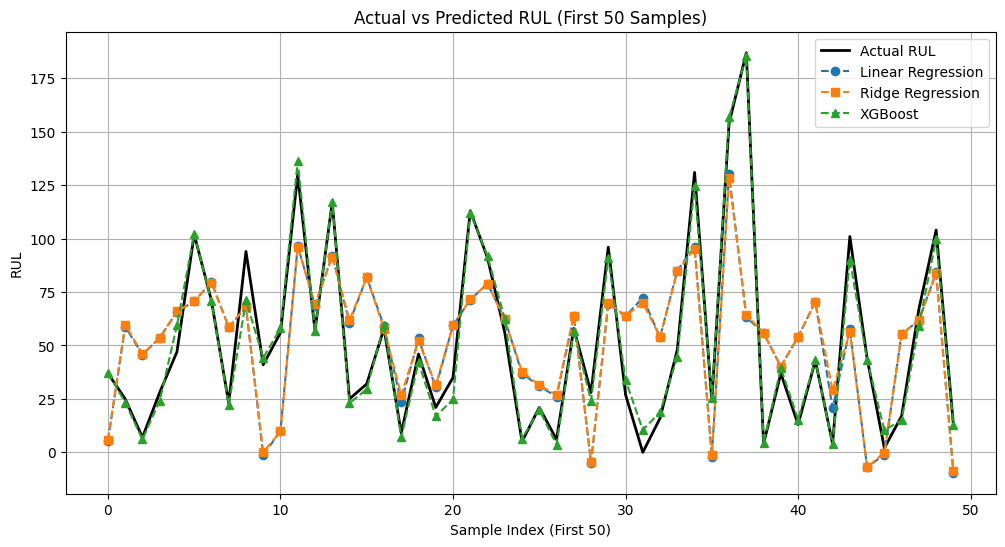

In [44]:
plt.figure(figsize=(12, 6))

# Plot actual RUL
plt.plot(y_test.values[:50], label="Actual RUL", color='black', linewidth=2)

# Plot predictions
plt.plot(y_pred_baseline[:50], label="Linear Regression", linestyle='--', marker='o')
plt.plot(y_pred_ridge[:50], label="Ridge Regression", linestyle='--', marker='s')
plt.plot(y_pred[:50], label="XGBoost", linestyle='--', marker='^')

plt.xlabel("Sample Index (First 50)")
plt.ylabel("RUL")
plt.title("Actual vs Predicted RUL (First 50 Samples)")
plt.legend()
plt.grid(True)
plt.show()

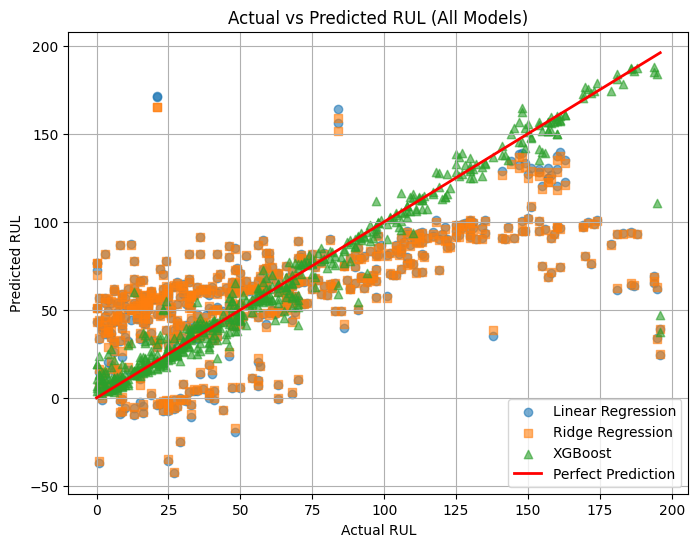

In [46]:
plt.figure(figsize=(8, 6))


plt.scatter(y_test, y_pred_baseline, alpha=0.6, label="Linear Regression", marker='o')
plt.scatter(y_test, y_pred_ridge, alpha=0.6, label="Ridge Regression", marker='s')
plt.scatter(y_test, y_pred, alpha=0.6, label="XGBoost", marker='^')

plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()],
         color='red', linewidth=2, label="Perfect Prediction")

plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("Actual vs Predicted RUL (All Models)")
plt.legend()
plt.grid(True)
plt.show()